In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys
import librosa as lr
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# import resampy
from concurrent.futures import ThreadPoolExecutor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# To play the audio files
from IPython.display import Audio

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [5]:
%cd AudioWAV

/content/drive/MyDrive/AudioWAV


In [6]:
Crema='/content/drive/MyDrive/AudioWAV/'

In [7]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if len(part) >= 3:
        if part[2] == 'SAD':
            file_emotion.append('Depressed')
        elif part[2] == 'DIS':
            file_emotion.append('Stressed')
        elif part[2] == 'FEA':
            file_emotion.append('Anxiety')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
    else:
        print(f"Skipping file {file} because it does not have an underscore character.")

#Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df = Crema_df[Crema_df['Emotions'] != 'unknown']
Crema_df.head()

Skipping file features.csv because it does not have an underscore character.


,Emotions,Path
0,Unknown,/content/drive/MyDrive/AudioWAV/1004_WSI_ANG_X...
1,Stressed,/content/drive/MyDrive/AudioWAV/1004_WSI_DIS_X...
2,neutral,/content/drive/MyDrive/AudioWAV/1004_TSI_NEU_X...
3,Unknown,/content/drive/MyDrive/AudioWAV/1004_WSI_HAP_X...
4,neutral,/content/drive/MyDrive/AudioWAV/1004_WSI_NEU_X...


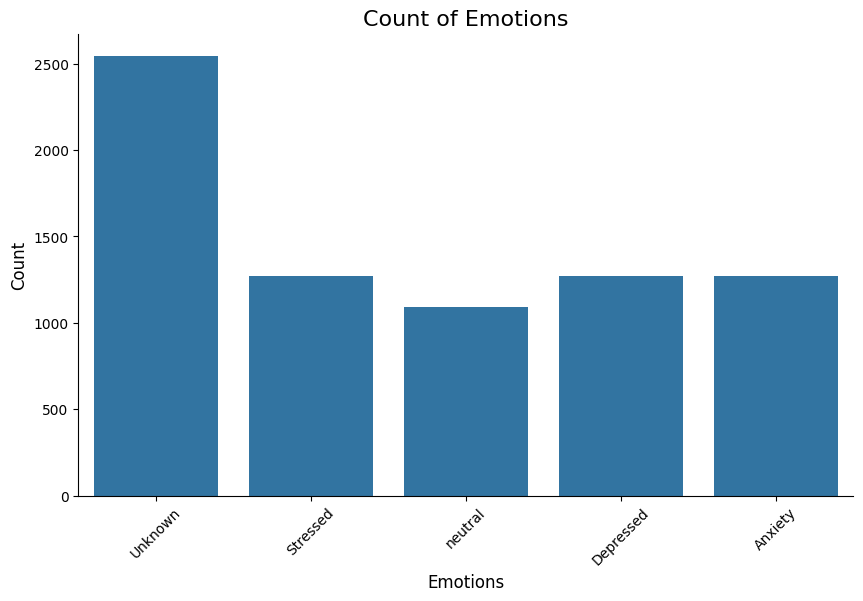

In [8]:
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.countplot(data = Crema_df, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=45)
plt.show()

In [9]:
print(Crema_df.shape)
Crema_df['Emotions'].value_counts()

(7453, 2)


Emotions
Unknown      2546
Depressed    1273
Stressed     1272
Anxiety      1272
neutral      1089
Name: count, dtype: int64

In [10]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)

# Taking any example and checking for techniques.
path = np.array(Crema_df.Path)[1]
data, sample_rate = librosa.load(path)

1.Simple Audio

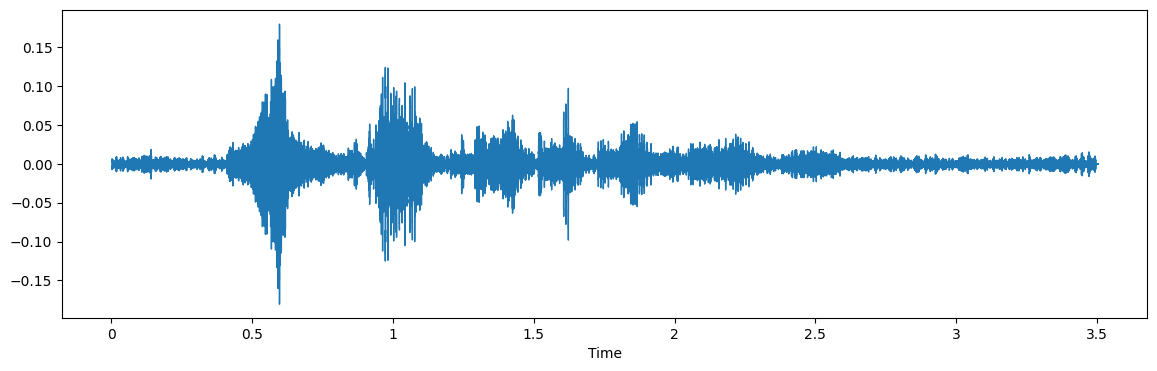

In [11]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

2. Noise Injection

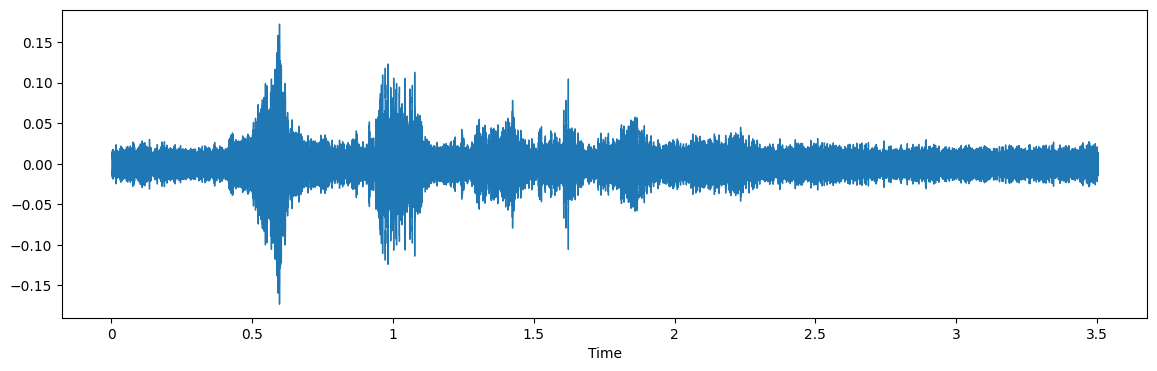

In [12]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

3. Stretching

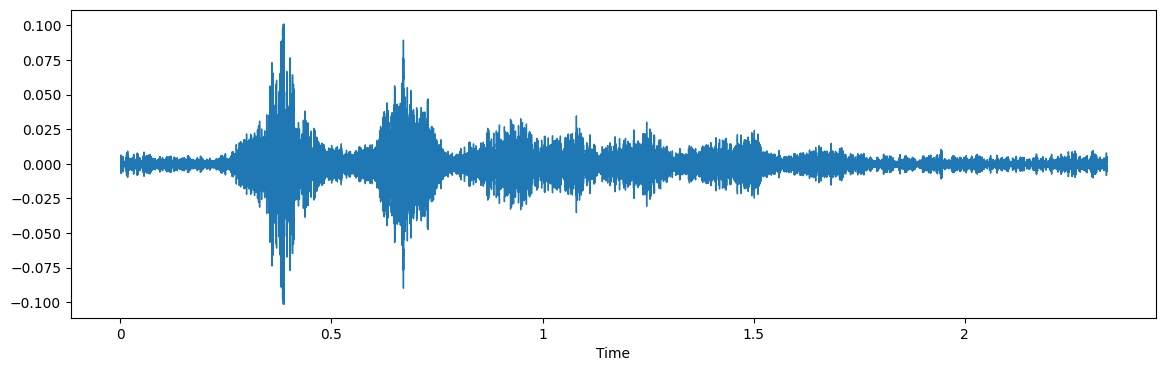

In [13]:
x = stretch(data, rate=1.5)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

4. Shifting

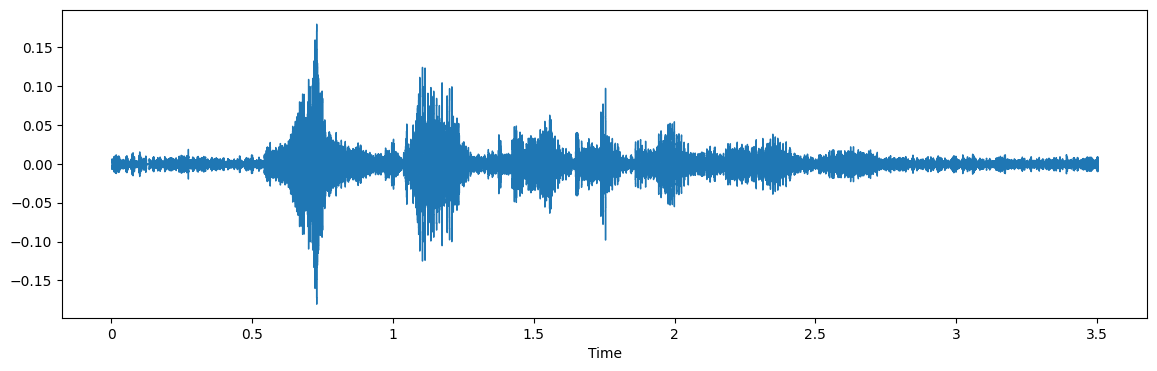

In [14]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

5. Pitch

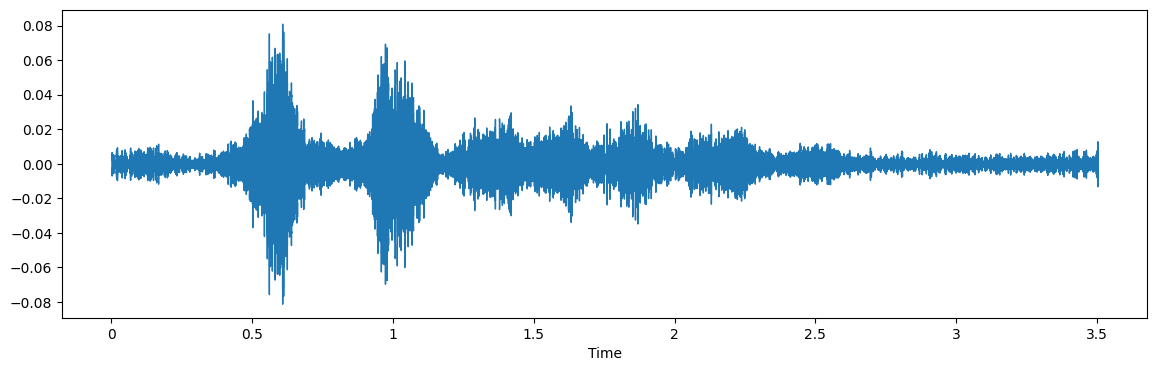

In [15]:
x = pitch(data, sample_rate, n_steps=-3)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**Feature Extraction**

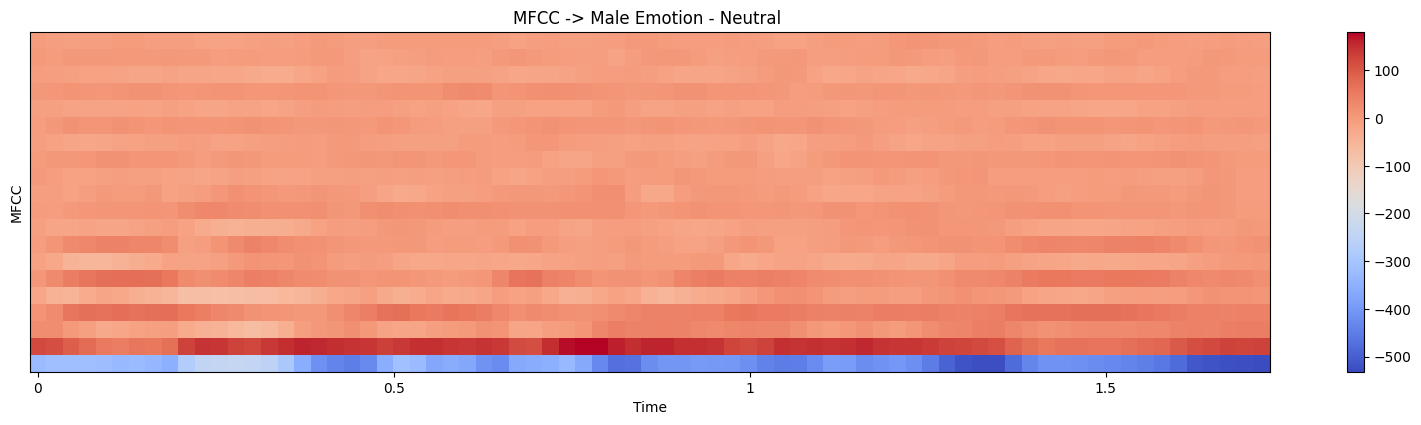

In [16]:
path = "/content/drive/MyDrive/AudioWAV/1091_WSI_NEU_XX.wav"
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
mfcc = librosa.feature.mfcc(y=data,sr=sample_rate,n_mfcc=20)

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc,x_axis='time')
plt.title('MFCC -> Male Emotion - Neutral ')
plt.ylabel('MFCC')
plt.colorbar()

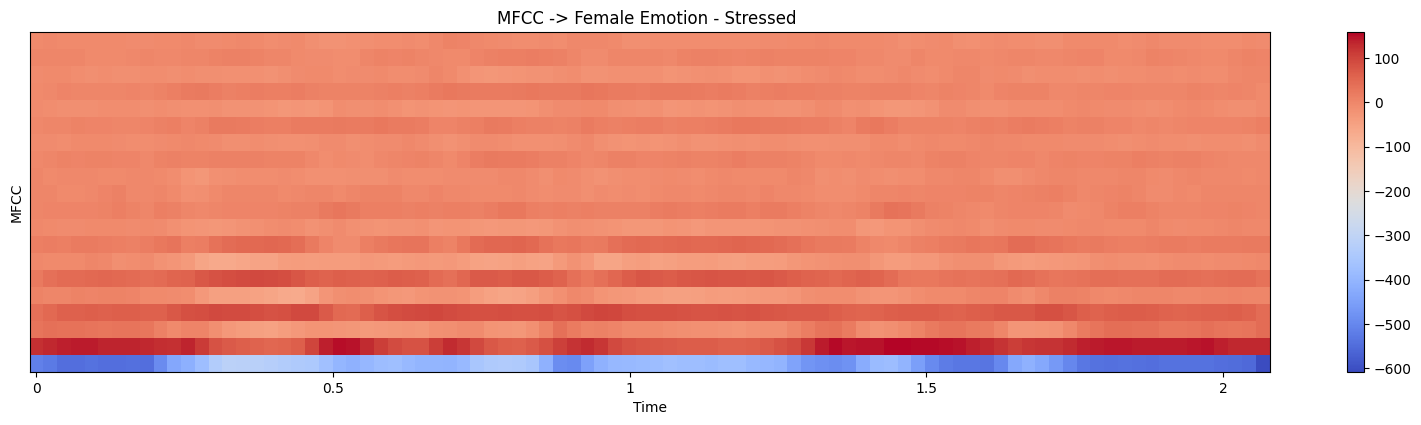

In [17]:
path = "/content/drive/MyDrive/AudioWAV/1091_TSI_DIS_XX.wav"
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
mfcc = librosa.feature.mfcc(y=data,sr=sample_rate,n_mfcc=20)

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc,x_axis='time')
plt.title('MFCC -> Female Emotion - Stressed ')
plt.ylabel('MFCC')
plt.colorbar()

In [18]:
def extract_features(data):
    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=20).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    return result

def get_features(path):
    # Duration and offset
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # Data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # Data with stretching (low speed)
    lowspeed_data = stretch(data, rate=0.7)
    res3 = extract_features(lowspeed_data)
    result = np.vstack((result, res3)) # stacking vertically

    # Data with stretching (high speed)
    highspeed_data = stretch(data, rate=1.25)
    res4 = extract_features(highspeed_data)
    result = np.vstack((result, res4)) # stacking vertically

    # Data with pitching
    pitch_data = pitch(data, sample_rate, n_steps=0.8)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5)) # stacking vertically

    # Data with shift
    shift_data = shift(data)
    res6 = extract_features(shift_data)
    result = np.vstack((result, res6)) # stacking vertically

    return result

In [19]:
# Appending emotion many times as we have made many augmentation techniques on each audio file.
def process_audio_file(path, emotion, X, Y):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    return (path, emotion)

if __name__ == "__main__":
    X, Y = [], []
    with ThreadPoolExecutor() as executor:
        futures = []
        for path, emotion in zip(Crema_df.Path, Crema_df.Emotions):
            future = executor.submit(process_audio_file, path, emotion, X, Y)
            futures.append(future)

        for future in futures:
            path, emotion = future.result()
            print(path, " : ", emotion)

/content/drive/MyDrive/AudioWAV/1004_WSI_ANG_XX.wav  :  Unknown
/content/drive/MyDrive/AudioWAV/1004_WSI_DIS_XX.wav  :  Stressed
/content/drive/MyDrive/AudioWAV/1004_TSI_NEU_XX.wav  :  neutral
/content/drive/MyDrive/AudioWAV/1004_WSI_HAP_XX.wav  :  Unknown
/content/drive/MyDrive/AudioWAV/1004_WSI_NEU_XX.wav  :  neutral
/content/drive/MyDrive/AudioWAV/1004_WSI_SAD_XX.wav  :  Depressed
/content/drive/MyDrive/AudioWAV/1005_DFA_ANG_XX.wav  :  Unknown
/content/drive/MyDrive/AudioWAV/1005_DFA_FEA_XX.wav  :  Anxiety
/content/drive/MyDrive/AudioWAV/1005_DFA_DIS_XX.wav  :  Stressed
/content/drive/MyDrive/AudioWAV/1005_DFA_HAP_XX.wav  :  Unknown
/content/drive/MyDrive/AudioWAV/1005_DFA_NEU_XX.wav  :  neutral
/content/drive/MyDrive/AudioWAV/1005_DFA_SAD_XX.wav  :  Depressed
/content/drive/MyDrive/AudioWAV/1005_IEO_ANG_HI.wav  :  Unknown
/content/drive/MyDrive/AudioWAV/1005_IEO_DIS_HI.wav  :  Stressed
/content/drive/MyDrive/AudioWAV/1005_IEO_ANG_MD.wav  :  Unknown
/content/drive/MyDrive/AudioWAV/1

<ipython-input-18-e52f2c66fb98>:12: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


/content/drive/MyDrive/AudioWAV/1016_TIE_ANG_XX.wav  :  Unknown
/content/drive/MyDrive/AudioWAV/1035_IEO_HAP_HI.wav  :  Unknown
/content/drive/MyDrive/AudioWAV/1025_ITS_DIS_XX.wav  :  Stressed
/content/drive/MyDrive/AudioWAV/1088_TAI_ANG_XX.wav  :  Unknown
/content/drive/MyDrive/AudioWAV/1088_MTI_HAP_XX.wav  :  Unknown


NoBackendError: 

In [20]:
len(X), len(Y), Crema_df.Path.shape

(44712, 44712, (7453,))

In [21]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-386.461670,137.547516,-20.179127,39.334072,-22.582426,27.230165,-27.843040,15.179662,-11.136623,0.224509,...,0.171603,0.672747,-13.952446,1.235635,-21.507998,4.446934,-13.569246,0.281331,-6.530354,Stressed
1,-272.095666,43.684231,16.276804,6.104396,3.377311,2.318321,-3.413090,-0.930414,-1.019538,-2.136003,...,-0.550555,-2.832167,-5.861810,-6.495785,-8.680415,-5.473335,-5.757881,-3.841942,-2.723544,Stressed
2,-419.511292,133.327240,-18.271095,36.698959,-21.344805,25.904943,-26.791637,14.128190,-10.680494,-1.042086,...,0.421387,0.296994,-13.603353,0.935758,-20.890059,4.017471,-13.338491,0.083883,-5.875398,Stressed
3,-421.305237,142.468094,-26.957893,43.176559,-28.602247,31.422138,-31.411161,17.115582,-13.007539,1.761100,...,1.041937,1.929280,-14.269427,2.341566,-22.735907,6.340185,-15.143164,0.483816,-7.692593,Stressed
4,-413.793427,129.238220,-16.757900,33.682209,-19.941679,23.862490,-27.296089,17.093267,-14.464797,2.794654,...,5.685405,-7.309928,-8.652758,-4.527339,-15.360943,4.396663,-15.142781,4.145298,-10.017553,Stressed


from matplotlib import pyplot as plt
_df_0[0].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1[1].plot(kind='hist', bins=20, title=1)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2[2].plot(kind='hist', bins=20, title=2)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3[3].plot(kind='hist', bins=20, title=3)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x=0, y=1, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x=1, y=2, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x=2, y=3, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x=3, y=4, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8[0].plot(kind='line', figsize=(8, 4), title=0)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9[1].plot(kind='line', figsize=(8, 4), title=1)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10[2].plot(kind='line', figsize=(8, 4), title=2)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11[3].plot(kind='line', figsize=(8, 4), title=3)
plt.gca().spines[['top', 'right']].set_visible(False)

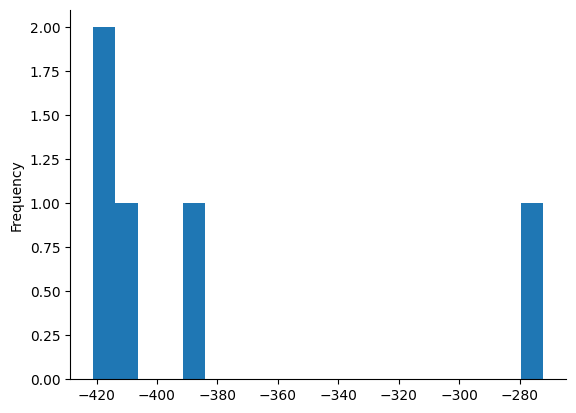

In [22]:
from matplotlib import pyplot as plt
_df_0[0].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

**Data Preparation**

In [23]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [24]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [25]:
# Splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33534, 20), (33534, 6), (11178, 20), (11178, 6))

In [26]:
# Scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33534, 20), (33534, 6), (11178, 20), (11178, 6))

In [27]:
# Do not run this cell if you use SVM model
# Making our data compatible to model 1D-CNN.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33534, 20, 1), (33534, 6), (11178, 20, 1), (11178, 6))

**Modelling**

In [30]:
# Creating the 1D-CNN model
model=Sequential()

model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu',\
                 input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))

model.add(Flatten())
model.add(Dense(units=4, activation='softmax'))

output_dim = 6  # Assuming you have 6 classes
model.add(Dense(output_dim, activation='softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'],run_eagerly=True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 20, 64)            256       
                                                                 
 conv1d_7 (Conv1D)           (None, 20, 64)            12352     
                                                                 
 dropout_2 (Dropout)         (None, 20, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 10, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 10, 128)           24704     
                                                                 
 conv1d_9 (Conv1D)           (None, 10, 128)           49280     
                                                      

In [31]:
n_epochs=100
batch_size_val=64

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
mdcp = ModelCheckpoint('best_model_weights.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=batch_size_val, epochs=n_epochs, \
                    validation_data=(x_test, y_test), callbacks=[rlrp, mdcp, early_stop])

Epoch 1/100
524/524 [==============================] - 69s 132ms/step - loss: 1.6105 - accuracy: 0.3443 - val_loss: 1.5908 - val_accuracy: 0.3338 - lr: 0.0010
Epoch 2/100
524/524 [==============================] - 66s 125ms/step - loss: 1.5742 - accuracy: 0.3443 - val_loss: 1.5760 - val_accuracy: 0.3338 - lr: 0.0010
Epoch 3/100
524/524 [==============================] - 69s 132ms/step - loss: 1.5646 - accuracy: 0.3443 - val_loss: 1.5693 - val_accuracy: 0.3338 - lr: 0.0010
Epoch 4/100
524/524 [==============================] - 68s 129ms/step - loss: 1.5601 - accuracy: 0.3443 - val_loss: 1.5661 - val_accuracy: 0.3338 - lr: 0.0010
Epoch 5/100
524/524 [==============================] - 67s 128ms/step - loss: 1.5576 - accuracy: 0.3443 - val_loss: 1.5643 - val_accuracy: 0.3338 - lr: 0.0010
Epoch 6/100
524/524 [==============================] - 72s 137ms/step - loss: 1.5561 - accuracy: 0.3443 - val_loss: 1.5630 - val_accuracy: 0.3338 - lr: 0.0010
Epoch 7/100
524/524 [=========================

**Training**

350/350 [==============================] - 11s 31ms/step - loss: 1.5908 - accuracy: 0.3338
Accuracy of 1D-CNN model on test data :  33.37806463241577 %


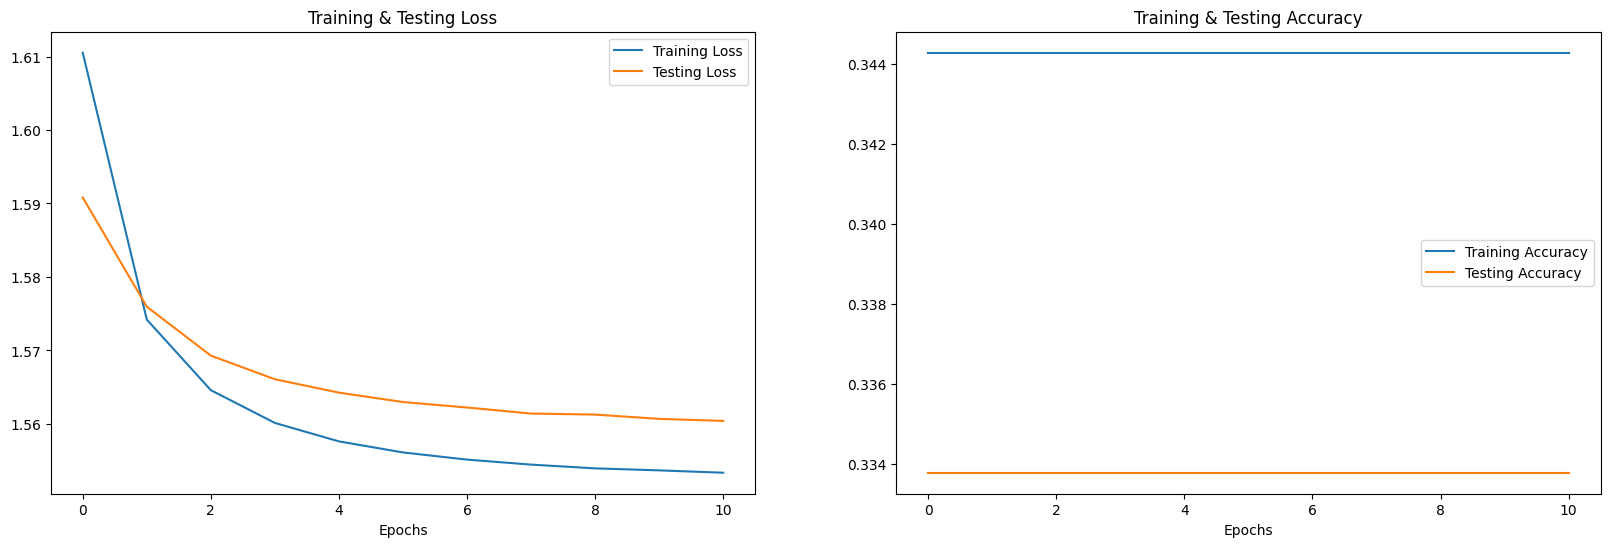

In [32]:
print("Accuracy of 1D-CNN model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")

epochs = [i for i in range(len(history.history['val_accuracy']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [33]:
# Predicting on test data
y_pred = model.predict(x_test)

350/350 [==============================] - 8s 22ms/step


In [76]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy_cnn = accuracy_score(y_test_labels, y_pred_labels)
precision_cnn = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall_cnn = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1_cnn = f1_score(y_test_labels, y_pred_labels, average='weighted')

print(f"Accuracy of the 1D-CNN Model: {accuracy_cnn}")
print(f"Precision of the 1D-CNN Model: {precision_cnn}")
print(f"Recall of the 1D-CNN Model: {recall_cnn}")
print(f"F1-score of the 1D-CNN Model: {f1_cnn}")

Accuracy of the 1D-CNN Model: 1.0
Precision of the 1D-CNN Model: 1.0
Recall of the 1D-CNN Model: 1.0
F1-score of the 1D-CNN Model: 1.0


In [38]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

,Predicted Labels,Actual Labels
0,Unknown,Stressed
1,Unknown,Depressed
2,Unknown,Anxiety
3,Unknown,Depressed
4,Unknown,Stressed
5,Unknown,Depressed
6,Unknown,neutral
7,Unknown,Depressed
8,Unknown,Depressed
9,Unknown,Stressed


from matplotlib import pyplot as plt
import seaborn as sns
_df_12.groupby('Actual Labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

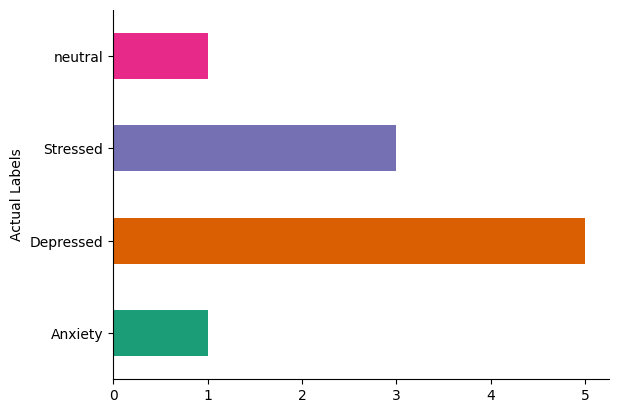

In [41]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_12.groupby('Actual Labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

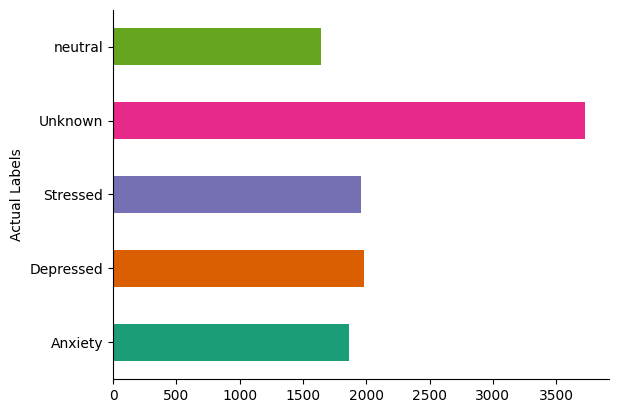

In [40]:
# @title Actual Labels

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Actual Labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)